In [11]:
from Model import *

# Root directory for dataset
dataroot = r'C:\Users\prave\Downloads\HW2\prob 2\Animal'
from torch.utils.data import ConcatDataset

In [12]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset1 = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

dataset2 = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.RandomRotation(degrees=random.choice([0, 20,50, 0, 0, 0])),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

dataset3 = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.RandomVerticalFlip(p=random.choice([0, 0.2,0.5, 0, 0, 0])),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

dataset4 = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.RandomHorizontalFlip(p=random.choice([0, 0.2,0.5, 0, 0, 0])),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

dataset5 = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.RandomAffine(degrees=(random.choice([0, 20,50, 0, 0, 0]))),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))




dataset = ConcatDataset([dataset1,dataset1,dataset1, dataset2, dataset3, dataset4, dataset5, dataset2,dataset3, dataset4,dataset5 ])

# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

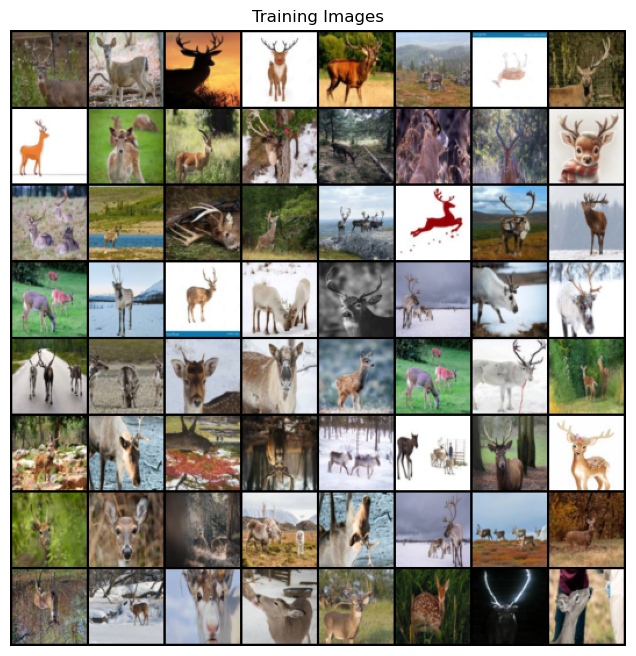

In [13]:
# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [14]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
#  to ``mean=0``, ``stdev=0.02``.
netG.apply(weights_init)



# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
# like this: ``to mean=0, stdev=0.2``.
netD.apply(weights_init)



# Initialize the ``BCELoss`` function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [15]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0
num_epochs= 150

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/150][0/77]	Loss_D: 1.9070	Loss_G: 2.2784	D(x): 0.2761	D(G(z)): 0.2217 / 0.1402
[0/150][50/77]	Loss_D: 0.0322	Loss_G: 18.1082	D(x): 0.9701	D(G(z)): 0.0000 / 0.0000
[1/150][0/77]	Loss_D: 0.0179	Loss_G: 38.8994	D(x): 0.9863	D(G(z)): 0.0000 / 0.0000
[1/150][50/77]	Loss_D: 0.0043	Loss_G: 38.2861	D(x): 0.9963	D(G(z)): 0.0000 / 0.0000
[2/150][0/77]	Loss_D: 0.0008	Loss_G: 37.8705	D(x): 0.9992	D(G(z)): 0.0000 / 0.0000
[2/150][50/77]	Loss_D: 0.0008	Loss_G: 35.8335	D(x): 0.9992	D(G(z)): 0.0000 / 0.0000
[3/150][0/77]	Loss_D: 0.0031	Loss_G: 36.1009	D(x): 0.9969	D(G(z)): 0.0000 / 0.0000
[3/150][50/77]	Loss_D: 0.6827	Loss_G: 4.4976	D(x): 0.8380	D(G(z)): 0.3204 / 0.0348
[4/150][0/77]	Loss_D: 0.3623	Loss_G: 4.4799	D(x): 0.8404	D(G(z)): 0.1413 / 0.0139
[4/150][50/77]	Loss_D: 0.4538	Loss_G: 4.5155	D(x): 0.7485	D(G(z)): 0.0935 / 0.0141
[5/150][0/77]	Loss_D: 0.1758	Loss_G: 5.0931	D(x): 0.9232	D(G(z)): 0.0806 / 0.0086
[5/150][50/77]	Loss_D: 0.1835	Loss_G: 5.4501	D(x): 0.9521	D(G

[49/150][0/77]	Loss_D: 0.0416	Loss_G: 5.0285	D(x): 0.9869	D(G(z)): 0.0272 / 0.0110
[49/150][50/77]	Loss_D: 0.0310	Loss_G: 5.3981	D(x): 0.9907	D(G(z)): 0.0208 / 0.0070
[50/150][0/77]	Loss_D: 0.0450	Loss_G: 4.8616	D(x): 0.9907	D(G(z)): 0.0337 / 0.0116
[50/150][50/77]	Loss_D: 0.0360	Loss_G: 5.1886	D(x): 0.9961	D(G(z)): 0.0310 / 0.0088
[51/150][0/77]	Loss_D: 0.0468	Loss_G: 4.6564	D(x): 0.9752	D(G(z)): 0.0202 / 0.0171
[51/150][50/77]	Loss_D: 0.0276	Loss_G: 5.0692	D(x): 0.9930	D(G(z)): 0.0200 / 0.0104
[52/150][0/77]	Loss_D: 0.0458	Loss_G: 5.0744	D(x): 0.9908	D(G(z)): 0.0344 / 0.0098
[52/150][50/77]	Loss_D: 0.0355	Loss_G: 5.0421	D(x): 0.9888	D(G(z)): 0.0232 / 0.0116
[53/150][0/77]	Loss_D: 0.0406	Loss_G: 4.9501	D(x): 0.9732	D(G(z)): 0.0127 / 0.0127
[53/150][50/77]	Loss_D: 0.0369	Loss_G: 5.0434	D(x): 0.9826	D(G(z)): 0.0189 / 0.0108
[54/150][0/77]	Loss_D: 0.0389	Loss_G: 5.5324	D(x): 0.9850	D(G(z)): 0.0223 / 0.0064
[54/150][50/77]	Loss_D: 0.0285	Loss_G: 5.3157	D(x): 0.9864	D(G(z)): 0.0143 / 0.009

[98/150][50/77]	Loss_D: 0.0110	Loss_G: 6.3917	D(x): 0.9947	D(G(z)): 0.0056 / 0.0039
[99/150][0/77]	Loss_D: 0.0133	Loss_G: 6.0942	D(x): 0.9935	D(G(z)): 0.0067 / 0.0048
[99/150][50/77]	Loss_D: 0.0140	Loss_G: 5.7316	D(x): 0.9976	D(G(z)): 0.0113 / 0.0064
[100/150][0/77]	Loss_D: 0.0092	Loss_G: 6.2661	D(x): 0.9983	D(G(z)): 0.0074 / 0.0040
[100/150][50/77]	Loss_D: 0.0098	Loss_G: 6.4199	D(x): 0.9953	D(G(z)): 0.0049 / 0.0035
[101/150][0/77]	Loss_D: 0.0167	Loss_G: 5.8138	D(x): 0.9955	D(G(z)): 0.0119 / 0.0056
[101/150][50/77]	Loss_D: 0.0121	Loss_G: 6.5010	D(x): 0.9917	D(G(z)): 0.0036 / 0.0035
[102/150][0/77]	Loss_D: 0.0098	Loss_G: 6.6401	D(x): 0.9939	D(G(z)): 0.0035 / 0.0025
[102/150][50/77]	Loss_D: 0.0120	Loss_G: 6.4631	D(x): 0.9923	D(G(z)): 0.0041 / 0.0035
[103/150][0/77]	Loss_D: 0.0058	Loss_G: 6.6849	D(x): 0.9983	D(G(z)): 0.0040 / 0.0028
[103/150][50/77]	Loss_D: 0.0711	Loss_G: 8.0509	D(x): 0.9988	D(G(z)): 0.0408 / 0.0041
[104/150][0/77]	Loss_D: 0.0103	Loss_G: 6.5006	D(x): 0.9964	D(G(z)): 0.006

[147/150][0/77]	Loss_D: 0.0163	Loss_G: 6.3010	D(x): 0.9920	D(G(z)): 0.0080 / 0.0033
[147/150][50/77]	Loss_D: 0.0113	Loss_G: 7.1776	D(x): 0.9968	D(G(z)): 0.0079 / 0.0020
[148/150][0/77]	Loss_D: 0.0113	Loss_G: 6.6081	D(x): 0.9948	D(G(z)): 0.0061 / 0.0023
[148/150][50/77]	Loss_D: 0.0364	Loss_G: 6.4357	D(x): 0.9741	D(G(z)): 0.0045 / 0.0051
[149/150][0/77]	Loss_D: 0.0240	Loss_G: 6.9685	D(x): 0.9844	D(G(z)): 0.0074 / 0.0032
[149/150][50/77]	Loss_D: 0.0279	Loss_G: 5.7230	D(x): 0.9802	D(G(z)): 0.0053 / 0.0069


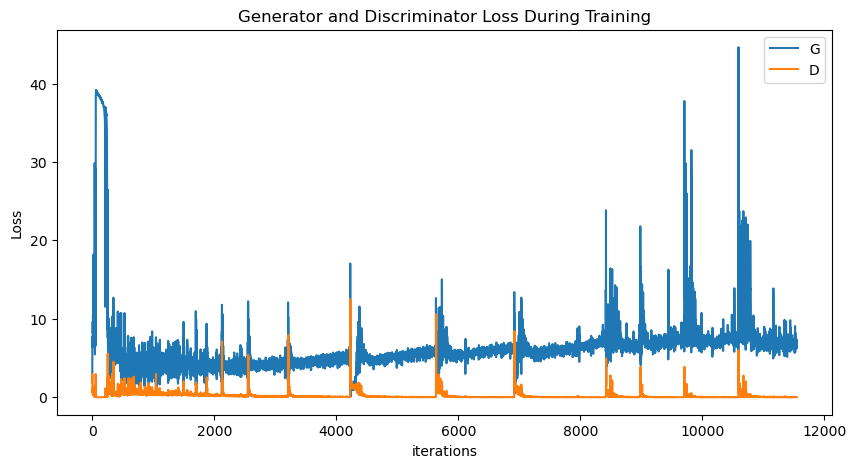

In [16]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

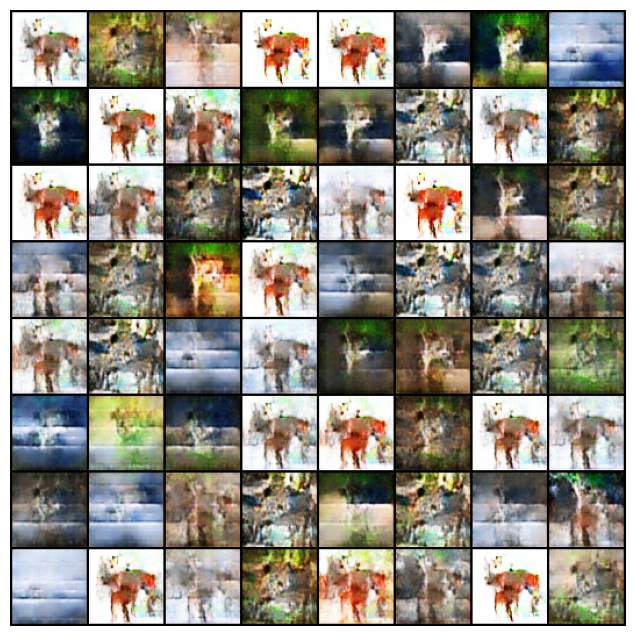

In [17]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]

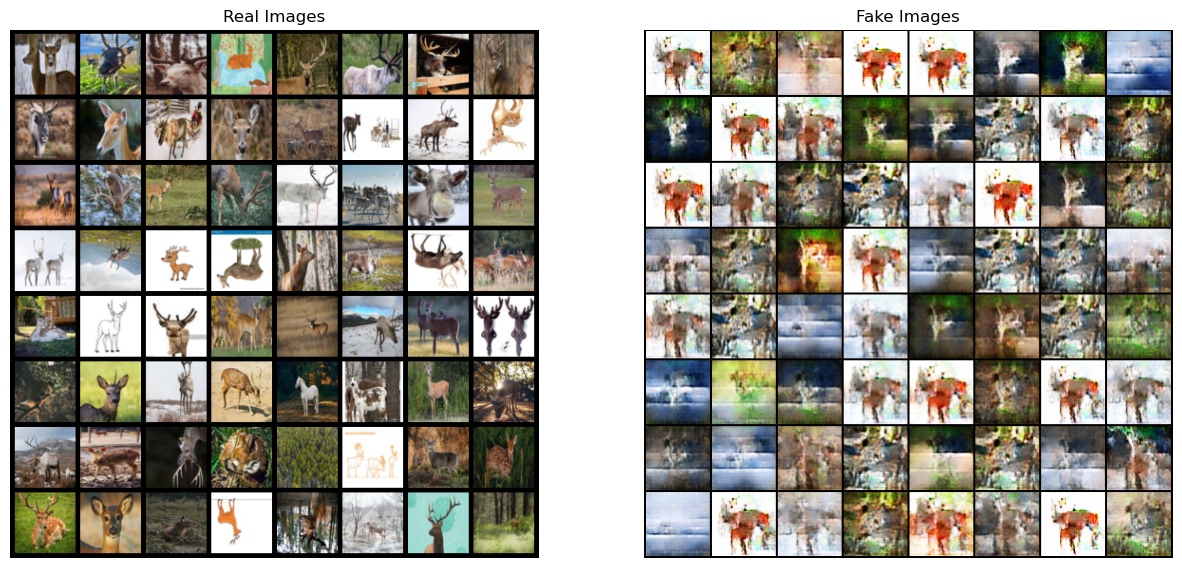

In [18]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()